# Modeling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, PrecisionRecallDisplay, precision_recall_curve
from sklearn.base import clone
from bayes_opt import BayesianOptimization
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("../src")
import utils

# rng = np.random.default_rng(10)

## Outline

1. Modeling TODO
    1. Baby recurrent neural network
        - 1 layer of <100 nodes
        - Gate parameters?
    1. Bayesian parameter search

## 0. Preface

As an introduction to the scope of the problem, let's begin by fitting a logistic regression with default parameters on the (smaller) balanced data. This is done in the next two code cells. The third code presents metrics for the model: classification reports for both training and test data, and a detail of the precision-recall curve for the testing data. These show a model that is able to catch fraud cases in the test data only at the expense of a large number of false positives: catching three quarters of fraud cases requires almost 50 false positives for every accurate fraud label.

The question, then, is how much lower can we get this false positive rate while still flagging a large share of fraudulent transactions for further investigation? This last point is important: a "false positive" can mean, in practice, declining a transaction until it is confirmed by the user, for example by responding to a text message. This is certainly a nuisance for customers, but it can be weighed against the benefit of preemptively catching a larger share of fraudulent activity.

In [3]:
# load balanced training data and test data
X_train = pd.read_csv(utils.prepend_dir('tx_train_balanced.csv'))
X_test = pd.read_csv(utils.prepend_dir('tx_test.csv'))

y_train = X_train.is_fraud
X_train.drop(columns='is_fraud', inplace=True)

y_test = X_test.is_fraud
X_test.drop(columns='is_fraud', inplace=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((27599, 28), (1176707, 28), (27599,), (1176707,))

In [4]:
# define and fit model
default_logit_pipe = make_pipeline(
    utils.MCCRates(),
    utils.MakeDummies('errors'),
    StandardScaler(),
    LogisticRegression()
    # SGDClassifier('log_loss')
)

default_logit_pipe.fit(X_train, y_train)
y_pred_train = default_logit_pipe.predict(X_train)
y_pred_test = default_logit_pipe.predict(X_test)

Training:
              precision    recall  f1-score   support

       False       0.89      0.87      0.88     13749
        True       0.87      0.89      0.88     13850

    accuracy                           0.88     27599
   macro avg       0.88      0.88      0.88     27599
weighted avg       0.88      0.88      0.88     27599

Validation:
              precision    recall  f1-score   support

       False       1.00      0.87      0.93   1175292
        True       0.01      0.91      0.02      1415

    accuracy                           0.87   1176707
   macro avg       0.50      0.89      0.47   1176707
weighted avg       1.00      0.87      0.93   1176707



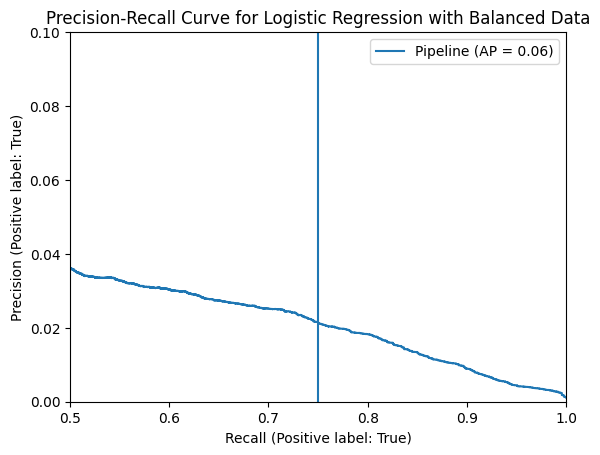

In [5]:
# show metrics
print('Training:')
print(classification_report(y_train, y_pred_train))
print('Validation:')
print(classification_report(y_test, y_pred_test))
prc_display = PrecisionRecallDisplay.from_estimator(default_logit_pipe, X_test, y_test)
plt.axvline(0.75);
plt.axis([0.5, 1., 0., 0.1]);
plt.legend(loc='upper right');
plt.title("Precision-Recall Curve for Logistic Regression with Balanced Data");

In [6]:
# memory is a constraint on my personal computer, so deleting everything from this preliminary analysis
del X_train, y_train, X_test, y_test, default_logit_pipe

## 1. Framework

This section sets up the models and parameter grids that will be assessed below. All information on models will be combined into list of dictionaries, each with the following elements:
1. `name`: A descriptive name
1. `estimator`: The full model pipeline, including needed transformations. Each pipeline consists of the replacement of `MCC` codes, the conversion of categorical variables (with or without drop-first dummy encoding), and standardization if necessary.
1. `paramaters`: A dictionary to be passed to `RandomSearchCV` for hyperparameter tuning.
1. `gridsize`: An integer indicating how many unique combinations of parameters there are. This will be used to determine the kind of search to perform.

In [7]:
# Shared transformers
mcc_convert = utils.MCCRates()
cat_convert_dummies = utils.MakeDummies('errors')
cat_convert_onehot = utils.MakeDummies('errors', drop_first=False)
standardize = StandardScaler()
# List containing the model information dictionaries
models = {}

def make_pipe_params(name, params):
    '''Appends the model name for setting parameters in a pipeline'''
    return {f'{name}__{key}':value for key, value in params.items()}

def gridsize(params):
    '''Counts the number of hyperparameters. Return a tuple of (number unique combinations, number of distinct values)'''
    total_prod = 1
    total_sum = 0
    for _, vals in params.items():
        total_prod *= len(vals)
        total_sum += len(vals)
    return total_prod, total_sum

def model_dict(name, components, params):
    return {
        'pipeline': make_pipeline(*components),
        'parameters': make_pipe_params(name, params),
        'gridsize': gridsize(params)
    }

Naive baseline "model": assigning a random probability to each case. No transformations are used here because they are irrelevant to the prediction.

In [8]:
models['naive'] = {
    'pipeline': utils.NaiveClassifier(),
    'parameters': {},
    'gridsize': (1, 1)
}

### Logistic regression

Requires drop-one encoding and standardization. Hyperparameters:
- C (regularization parameter): `1e-3...1e2`

In [9]:
name = 'logisticregression'
components = [
    mcc_convert,
    cat_convert_dummies,
    standardize,
    LogisticRegression(class_weight='balanced', max_iter=1000)
]

parameters = {
    # 'penalty': ['l1', 'l2'],
    'C': [10.**x for x in range(-3, 3)]
}

models[name] = model_dict(name, components, parameters)

### SGD with alternative loss functions and regularization

The solvers for scikit-learn's `LogisticRegression` model that are compatible with penalties other than `L2` fail to converge in a reasonable time frame. `SGDClassifier` is compatible with `elasticnet` penalty, which combines L1 and L2 (and can be equivalent to them with the appropriate parameter).

Hyperparameters:
- Loss function: log (like logistic regression), modified Huber
- Regularization parameter (alpha, higher is stronger): 1e-6 ... 1e2
- L1 ratio: 0 (=L2 penalty), 0.1, 0.2 ... 1 (=L1 penalty)

In [10]:
name = 'sgdclassifier'

components = [
    mcc_convert,
    cat_convert_dummies,
    standardize,
    SGDClassifier(class_weight='balanced', penalty='elasticnet')
]

parameters = {
    'loss': ['log_loss', 'modified_huber'],
    'alpha': [10**x for x in range(-6, 3)],
    'l1_ratio': [x/10. for x in range(11)]
}

models[name] = model_dict(name, components, parameters)

### Kernel SVM

Requires drop-one encoding and standardization. Note that the precision-recall curve will be calculated using `.decision_function()`, which is based on distance from the separating hyperplane. Hyperparameters:
- C (regularization parameter): `1e-3...1e1`
- Kernel: `poly`, `rbf`
- Degree (for polynomial): `2...4`
- Gamma (kernel weight parameter): `scale`, `auto`, `1e-3...1e0`

In [11]:
# components = [
#     mcc_convert,
#     cat_convert_dummies,
#     standardize,
#     SVC(class_weight='balanced', max_iter=1000)
# ]

# parameters = {
#     'C': [10.**x for x in range(-3, 2)],
#     'kernel': ['poly', 'rbf'],
#     'degree': list(range(2, 5)),
#     'gamma': ['scale', 'auto'] + [10.**x for x in range(-3, 1)]
# }

# models.append(model_dict('svc', components, parameters))

### Random Forest

Does not require drop-first encoding or standardization. Hyperparameters:
- Number of estimators: 50, 100, 200, 400, 800
- Maximum depth of trees: None, 10, 20, 40
- Minimum samples per leaf: 1, 10, 50
- Complexity parameter for minimal cost-complexity pruning: `1e-3 ... 1e-1`
- Class weight: 'balanced', 'balanced_subsample'

Note that although random forests can be fit in parallel, the parameter search functions will be set for parallelize instead.

In [12]:
name = 'randomforestclassifier'

components = [
    mcc_convert,
    cat_convert_onehot,
    RandomForestClassifier()
]

parameters = {
    'n_estimators': [50*2**x for x in range(5)],
    'max_depth': [None, 10, 20, 40, 80],
    'min_samples_leaf': [1, 10, 50, 100],
    'ccp_alpha': [0.0] + [10.**x for x in range(-3, 0)],
    'class_weight': ['balanced', 'balanced_subsample']
}

models[name] = model_dict(name, components, parameters)

### AdaBoost

Does not require drop-first encoding or standardization. Hyperparameters:
- Number of estimators: 50, 100, 200, 400, 800
- Learning rate: `1e-4...1`

In [13]:
name = 'adaboostclassifier'

components = [
    mcc_convert,
    cat_convert_onehot,
    AdaBoostClassifier()
]

parameters = {
    'n_estimators': [50*2**x for x in range(5)],
    'learning_rate': [10.**x for x in range(-4, 1)]
}

models[name] = model_dict(name, components, parameters)

### XGBoost

Does not require drop-first encoding or standardization. Hyperparameters:
- Learning rate: `1e-2...1e1`
- Max depth of trees: 2, 4, 8, 16
- Minimum child weight: 1, 10

In [14]:
name = 'xgbclassifier'

components = [
    mcc_convert,
    cat_convert_onehot,
    XGBClassifier(objective='binary:logistic')
]

parameters = {
    'learning_rate': [10.**x for x in range(-4, 2)],
    'max_depth': [2*2**x for x in range(5)],
    'min_child_weight': [1, 10, 20, 30]
}

models[name] = model_dict(name, components, parameters)

## 2. Tuning

This section measured the performance of the various model and hyperparamter combinations with 5-fold cross-validation. It uses both the balanced and unbalanced training data sets. Model performance is measured with F1 scores, because not every model can output probabilities. For the best-performing estimator is then saved for evaluation later.

Note: the hyperparameter search is performed differently based on the size of the grid:
- For up to 50 parameter combinations: exhaustive grid search.
- For more than 50 combinations: random search with $3n$ samples, where $n$ is the sum of distinct hyperparameter values.

### 2.1 Balanced data

In [15]:
# Loading data

X_train = pd.read_csv(utils.prepend_dir('tx_train_balanced.csv'))
y_train = X_train.is_fraud
X_train.drop(columns='is_fraud', inplace=True)

In [16]:
# Iterating through models
for name, model in models.items():
    combinations, count = model['gridsize']
    print(f'{name}: {combinations = } vs. iterations = {count*3}')
    
    # Determine search method: grid or randomized
    if combinations <= 50 or combinations <= count*3:
        searcher = GridSearchCV(
            model['pipeline'], 
            param_grid=model['parameters'], 
            n_jobs=-1, 
            scoring='f1',
            verbose=1)
    else: 
        searcher = RandomizedSearchCV(
            model['pipeline'], 
            param_distributions=model['parameters'], 
            n_iter=count*3, 
            n_jobs=-1, 
            scoring='f1',
            verbose=1)
    
    searcher.fit(X_train, y_train)
    
    # print and save results
    print(searcher.best_score_, searcher.best_params_)
    results = {
        'best_estimator': searcher.best_estimator_,
        'best_params': searcher.best_params_,
        'best_score': searcher.best_score_,
        'results_table': pd.DataFrame(searcher.cv_results_)
    }
    model.update(results)

naive: combinations = 1 vs. iterations = 3
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.5050013359582421 {}
logisticregression: combinations = 6 vs. iterations = 18
Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.880209063282335 {'logisticregression__C': 10.0}
sgdclassifier: combinations = 198 vs. iterations = 66
Fitting 5 folds for each of 66 candidates, totalling 330 fits
0.8781882713254554 {'sgdclassifier__loss': 'log_loss', 'sgdclassifier__l1_ratio': 0.9, 'sgdclassifier__alpha': 0.001}
randomforestclassifier: combinations = 800 vs. iterations = 60
Fitting 5 folds for each of 60 candidates, totalling 300 fits
0.90750137875766 {'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__min_samples_leaf': 50, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__ccp_alpha': 0.0}
adaboostclassifier: combinations = 25 vs. iterations = 30
Fitting 5 folds for each of 25 candidates, tota

### 2.2 Bayesian Optimization

As an alternative method, we can employ Bayesian Optimization. The code in the following cells converts the parameter grids to parameter ranges and does the setup needed to handled categorical parameters.

In [17]:
class BayesOptWrapper():
    def __init__(self, pipeline, parameters) -> None:
        # make parameter dictionary formatted for BayesOpt and converter to pass to model
        self.opt_params = {}
        self.param_converters = {}
        for param, values in parameters.items():
            ints = []
            floats = []
            categories = []
            for val in values:
                if type(val) == str or type(val) == type(None):
                    categories.append(val)
                elif type(val) == int:
                    ints.append(val)
                elif type(val) == float:
                    floats.append(val)
            if len(categories) == 0:
                # only numerical values
                if len(floats) > 0:
                    # use log scale for parameters expected to mostly be in (0,1]
                    if min(floats)>0 and min(floats)<1:
                        self.opt_params[param] = (np.log(min(ints+floats)), np.log(max(ints+floats)))
                        self.param_converters[param] = lambda val: np.exp(val)
                    else:
                        self.opt_params[param] = (min(ints + floats), max(ints + floats))
                        self.param_converters[param] = lambda val: val
                else:
                    self.opt_params[param] = (min(ints), max(ints)+.9999)
                    self.param_converters[param] = lambda val: int(val)
            elif len(categories) == 1:
                cat_val = categories[0]
                self.opt_params[param] = (0, max(ints)+0.9999) # because int() truncates
                if len(floats) > 0:
                    raise ValueError('Cannot combine category with floats')
                else:
                    self.param_converters[param] = lambda val, cat_val=cat_val: cat_val if int(val) == 0 else floor(val)
            else:
                # treat all of the options as categories
                categories += floats + ints
                self.opt_params[param] = (0, len(categories)-0.0001)
                self.param_converters[param] = lambda val, categories=categories.copy(): categories[int(val)]
        
        # save a copy of the estimator pipeline
        self.estimator = clone(pipeline)


    def convert_params(self, **parameters):
        '''Take the floating point parameters generated by BayesOpt and converts them to the appropriate values for the model (e.g. integers or strings)'''
        return {param:self.param_converters[param](val) for param, val in parameters.items()}

    
    def optimize(self, X, y, init_points, n_iter):
        '''Returns tuple of best score, dict of best parameters, and optimized estimator'''
        # make cv scorer function
        scorer = lambda **parameters: np.mean(cross_val_score(
            self.estimator.set_params(**self.convert_params(**parameters)), 
            X, 
            y, 
            scoring='f1',
            n_jobs=-1,
            cv=5))
        optimizer = BayesianOptimization(
            f = scorer,
            pbounds = self.opt_params,
            verbose = 1
        )
        optimizer.maximize(init_points=init_points, n_iter=n_iter)
        best_params = self.convert_params(**optimizer.max['params'])
        refit_model = clone(self.estimator).set_params(**best_params)
        refit_model.fit(X, y)
        return optimizer.max['target'], best_params, refit_model

In [18]:
bayes_opt_results = {}
for name, model in models.items():
    if name=='naive': continue
    print(f'******{name}******')
    optimizer = BayesOptWrapper(model['pipeline'], model['parameters'])
    best_score, best_params, best_estimator = optimizer.optimize(X_train, y_train, 10, 50)
    bayes_opt_results[name] = {
        'best_score': best_score,
        'best_params': best_params,
        'best_estimator': best_estimator
    }

******logisticregression******
|   iter    |  target   | logist... |
-------------------------------------
| 5         | 0.8803    | 41.59     |
******sgdclassifier******
|   iter    |  target   | sgdcla... | sgdcla... | sgdcla... |
-------------------------------------------------------------
| 2         | 0.401     | 70.03     | 0.3968    | 1.735     |
| 3         | 0.401     | 27.29     | 0.903     | 0.6438    |
| 10        | 0.5346    | 65.77     | 0.9715    | 0.5297    |
******randomforestclassifier******
|   iter    |  target   | random... | random... | random... | random... | random... |
-------------------------------------------------------------------------------------
| 4         | 0.8548    | 0.04324   | 0.4883    | 11.94     | 12.43     | 772.4     |
| 5         | 0.8622    | 0.0108    | 1.344     | 42.51     | 93.85     | 777.9     |
| 11        | 0.869     | 0.008375  | 1.835     | 79.71     | 70.72     | 798.4     |
| 38        | 0.884     | 0.006229  | 0.5133    | 22.5

### 2.2 Unbalanced data

In [19]:
# delete the training data to free up memory

del X_train, y_train

## 3. Evaluation

To compare the results of the different kinds of models, the code below outputs 3 set of metrics, all using the held-back test data:
1. A classification performance table using a 0.5 probability theshold.
1. A precision-recall curve, zoomed on the portion above 50% recall. The red line in these graphs marks 75% recall.
1. Comparing the precision of each model with 75% recall. This is express both as a rate and as the number of false positives per accurately caught instance of fraud.

In [20]:
def assess_model(model, name, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    test_fraud_prob = model.predict_proba(X_test)[:,1]

    # precision-recall plot
    # _ = PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
    _ = PrecisionRecallDisplay.from_predictions(y_test, test_fraud_prob)
    plt.axvline(0.75, color='red');
    plt.axis([0.5, 1., 0., 0.25]);
    plt.legend(loc='upper right');
    plt.title(f"Precision-Recall Curve for {name}");
    
    # save precision-recall table
    precision, recall, thresholds = precision_recall_curve(y_test, test_fraud_prob)
    prc = pd.DataFrame({
        'precision':precision[:-1],
        'recall': recall[:-1]},
        index=thresholds
    )
    return prc[prc.recall>=0.75].precision.max()

X_test = pd.read_csv(utils.prepend_dir('tx_test.csv'))
y_test = X_test.is_fraud
X_test.drop(columns='is_fraud', inplace=True)
names = []
prec75 = []

********naive********
Series([], dtype: object)
              precision    recall  f1-score   support

       False       1.00      0.50      0.67   1175292
        True       0.00      0.48      0.00      1415

    accuracy                           0.50   1176707
   macro avg       0.50      0.49      0.33   1176707
weighted avg       1.00      0.50      0.67   1176707


********logisticregression********
logisticregression__C    10.0
dtype: float64
              precision    recall  f1-score   support

       False       1.00      0.87      0.93   1175292
        True       0.01      0.91      0.02      1415

    accuracy                           0.87   1176707
   macro avg       0.50      0.89      0.47   1176707
weighted avg       1.00      0.87      0.93   1176707


********sgdclassifier********
sgdclassifier__loss        log_loss
sgdclassifier__l1_ratio         0.9
sgdclassifier__alpha          0.001
dtype: object
              precision    recall  f1-score   support

       Fa

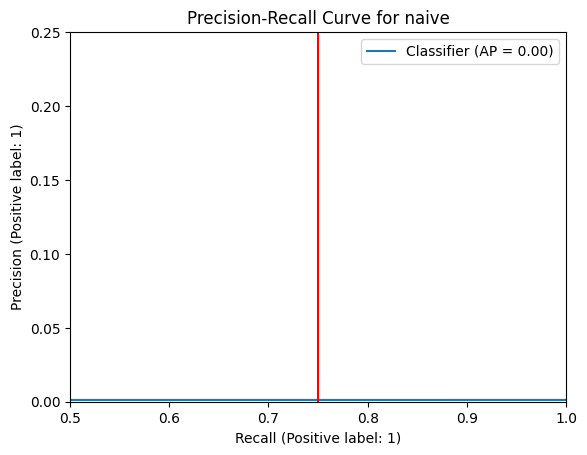

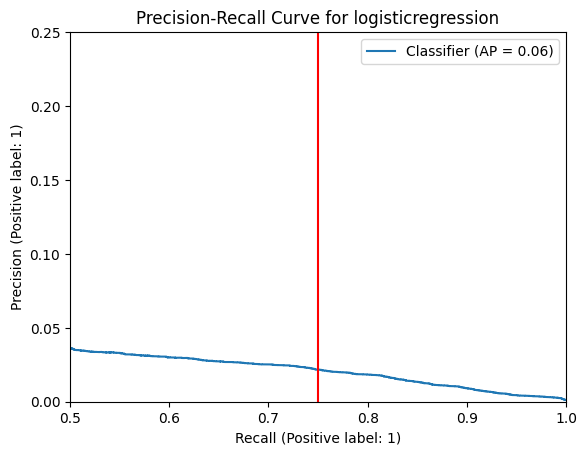

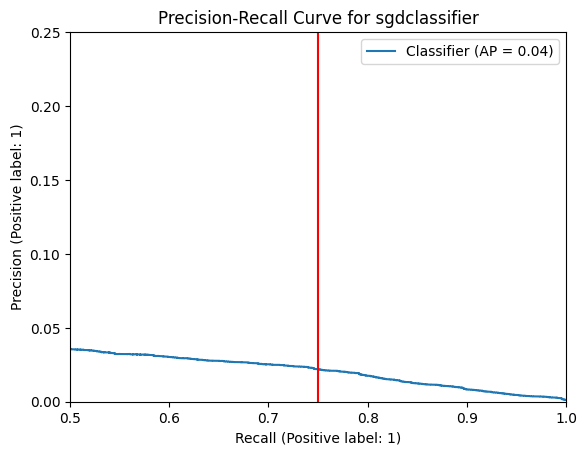

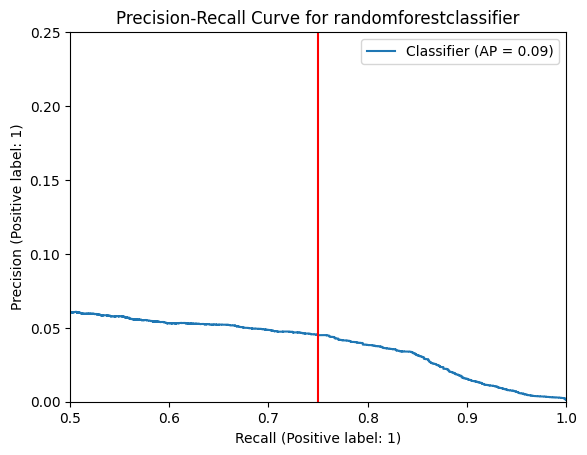

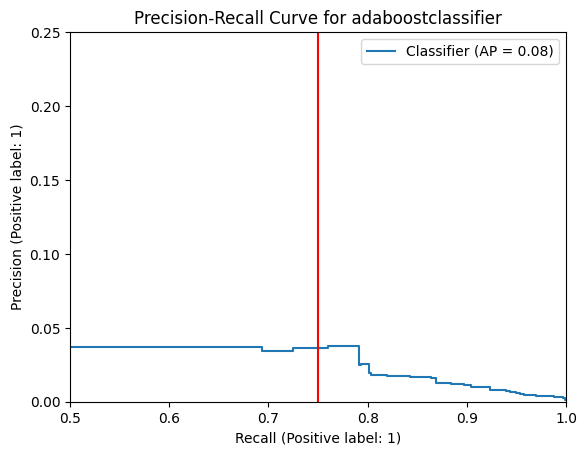

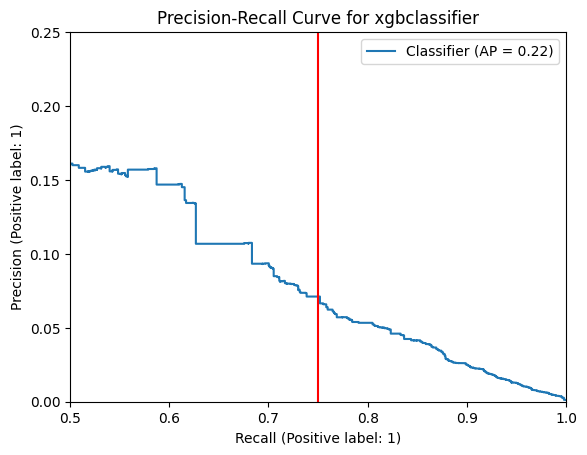

In [21]:
for name, model in models.items():
    # if name=='naive': continue
    print(f'********{name}********')
    print(pd.Series(model['best_params']))
    model['prec75'] = assess_model(model['best_estimator'], name, X_test, y_test)
    names.append(name+'_search')
    prec75.append(model['prec75'])
    print()

********logisticregression********
logisticregression__C    41.592532
dtype: float64
              precision    recall  f1-score   support

       False       1.00      0.87      0.93   1175292
        True       0.01      0.91      0.02      1415

    accuracy                           0.87   1176707
   macro avg       0.50      0.89      0.47   1176707
weighted avg       1.00      0.87      0.93   1176707


********sgdclassifier********
sgdclassifier__alpha       65.77005
sgdclassifier__l1_ratio    0.971459
sgdclassifier__loss        log_loss
dtype: object


c:\Users\marks\.virtualenvs\CreditCardFraud-UbjN0nMT\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marks\.virtualenvs\CreditCardFraud-UbjN0nMT\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marks\.virtualenvs\CreditCardFraud-UbjN0nMT\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

       False       0.00      0.00      0.00   1175292
        True       0.00      1.00      0.00      1415

    accuracy                           0.00   1176707
   macro avg       0.00      0.50      0.00   1176707
weighted avg       0.00      0.00      0.00   1176707


********randomforestclassifier********
randomforestclassifier__ccp_alpha           0.000897
randomforestclassifier__class_weight        balanced
randomforestclassifier__max_depth                 78
randomforestclassifier__min_samples_leaf          70
randomforestclassifier__n_estimators             799
dtype: object
              precision    recall  f1-score   support

       False       1.00      0.92      0.96   1175292
        True       0.01      0.91      0.03      1415

    accuracy                           0.92   1176707
   macro avg       0.51      0.91      0.49   1176707
weighted avg       1.00      0.92      0.96   1176707


********adaboostclassifier

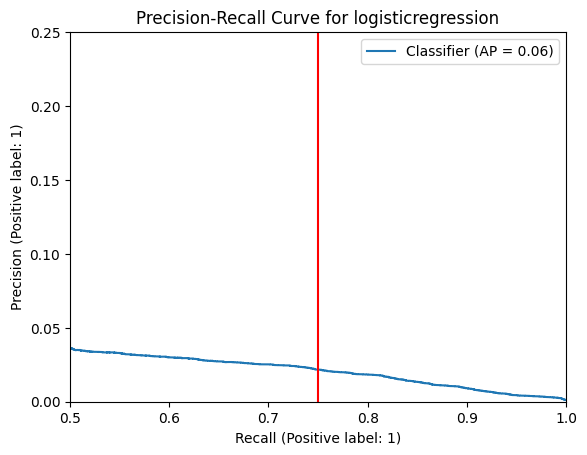

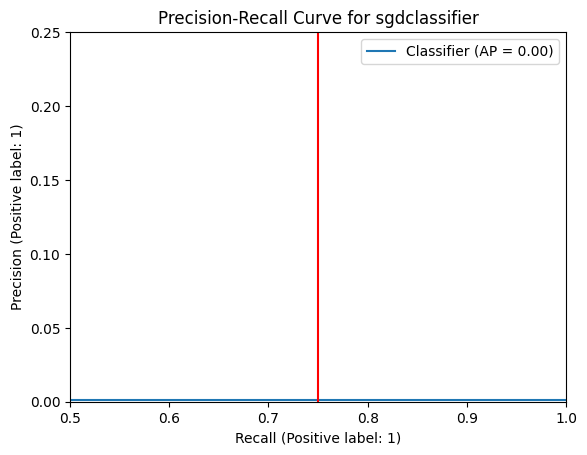

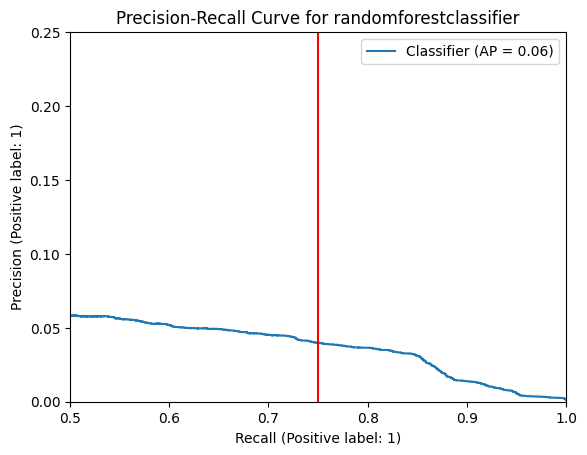

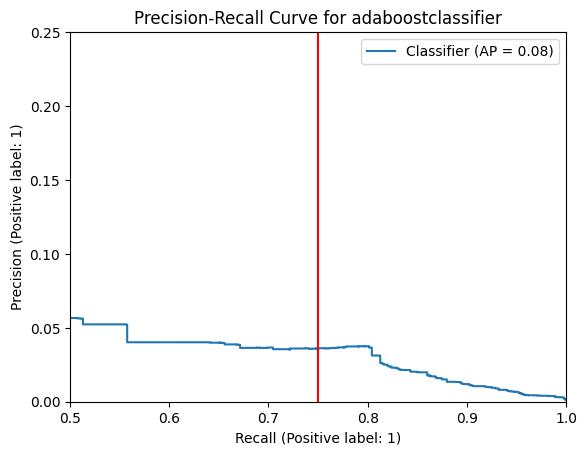

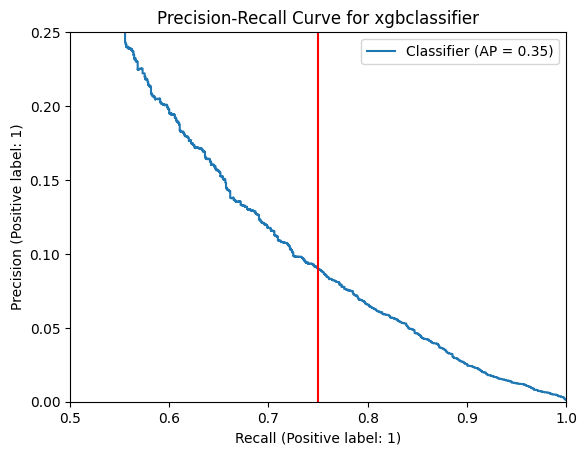

In [22]:
for name, results in bayes_opt_results.items():
    if name=='naive': continue
    print(f'********{name}********')
    print(pd.Series(results['best_params']))
    results['prec75'] = assess_model(results['best_estimator'], name, X_test, y_test)
    names.append(name+'_BayesOpt')
    prec75.append(results['prec75'])
    print()

In [23]:
recall_data = pd.DataFrame({'names': names, 'prec75':prec75})
recall_data['false_positives_per_true'] = 1/ recall_data.prec75 - 1
recall_data.sort_values('prec75', ascending=False)

,names,prec75,false_positives_per_true
10,xgbclassifier_BayesOpt,0.089985,10.112994
5,xgbclassifier_search,0.071166,13.051740
3,randomforestclassifier_search,0.045134,21.156075
8,randomforestclassifier_BayesOpt,0.039826,24.109023
9,adaboostclassifier_BayesOpt,0.037601,25.594858
4,adaboostclassifier_search,0.037421,25.722967
2,sgdclassifier_search,0.021998,44.459510
6,logisticregression_BayesOpt,0.021688,45.108184
1,logisticregression_search,0.021665,45.158192
0,naive_search,0.001210,825.194424


The result is that ensemble methods strongly out-perform the linear methods, and in particular, XGBoost does substantially better than any alternative. It has 10 false postives for every true when catching 75% of fraud cases. This is still far from adequate if the goal were to be to definitively identify instances of fraud. But as a warning flag to at least consider further investigation or confirmation from the customer, it is an immense improvement from a naive "needle in the haystack" approach.

Indeed, if the preference is to ensure higher precision, the Bayesian-tuned XBoost model can catch about a quarter of fraud cases while flagging about one false positive per correct prediction.

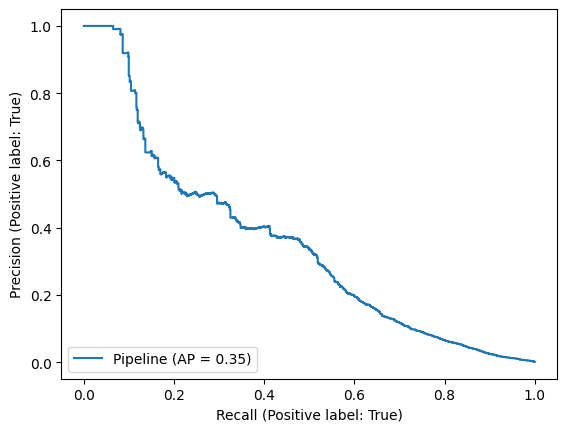

In [24]:
_ = PrecisionRecallDisplay.from_estimator(bayes_opt_results['xgbclassifier']['best_estimator'], X_test, y_test)

In [35]:
utils.save_model('xgbclassifier_bayesopt', bayes_opt_results['xgbclassifier'])